# Import Libraries

In [1]:
# For Data Manipulation
import pandas as pd
import numpy as np

# For Text Preprocessing
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split

# For NLP
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# For Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Global\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Global\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Load the Datasets

In [2]:
# Load Twitter Scraping Tweets Dataset
tweets_df = pd.read_csv("Twitter Scraping Tweets Dataset.csv")

# Load twitter_training and twitter_validation datasets
train_df = pd.read_csv("twitter_training.csv")
val_df = pd.read_csv("twitter_validation.csv")

In [3]:
# Check the columns in each dataframe
print(train_df.columns)
print(val_df.columns)
print(tweets_df.columns)

Index(['2401', 'Borderlands', 'Positive',
       'im getting on borderlands and i will murder you all ,'],
      dtype='object')
Index(['3364', 'Facebook', 'Irrelevant',
       'I mentioned on Facebook that I was struggling for motivation to go for a run the other day, which has been translated by Tom’s great auntie as ‘Hayley can’t get out of bed’ and told to his grandma, who now thinks I’m a lazy, terrible person 🤣'],
      dtype='object')
Index(['Unnamed: 0', 'user_name', 'user_location', 'user_description',
       'user_verified', 'date', 'text', 'hashtags', 'source', 'label'],
      dtype='object')


In [4]:
# Check the columns and contents
print(train_df.head())  # Check first few rows of train data
print(val_df.head())    # Check first few rows of validation data
print(tweets_df.head()) # Check first few rows of tweet data

   2401  Borderlands  Positive  \
0  2401  Borderlands  Positive   
1  2401  Borderlands  Positive   
2  2401  Borderlands  Positive   
3  2401  Borderlands  Positive   
4  2401  Borderlands  Positive   

  im getting on borderlands and i will murder you all ,  
0  I am coming to the borders and I will kill you...     
1  im getting on borderlands and i will kill you ...     
2  im coming on borderlands and i will murder you...     
3  im getting on borderlands 2 and i will murder ...     
4  im getting into borderlands and i can murder y...     
   3364   Facebook Irrelevant  \
0   352     Amazon    Neutral   
1  8312  Microsoft   Negative   
2  4371      CS-GO   Negative   
3  4433     Google    Neutral   
4  6273       FIFA   Negative   

  I mentioned on Facebook that I was struggling for motivation to go for a run the other day, which has been translated by Tom’s great auntie as ‘Hayley can’t get out of bed’ and told to his grandma, who now thinks I’m a lazy, terrible person 🤣  
0

# Data Preprocessing
**Clean the Text Data**

In [5]:
# Function to clean tweet text
def clean_text(text):
    if isinstance(text, str):  # Ensure the text input is a string
        text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)  # Remove URLs
        text = re.sub(r'\@\w+|\#', '', text)  # Remove mentions and hashtags
        text = re.sub(r'[^A-Za-z0-9\s]+', '', text)  # Remove special characters
        text = text.lower()  # Convert to lowercase
        return text
    return ''  # Return empty string if not valid

# Applying the clean_text function
# For train_df and val_df, the text appears to be in the 4th column (index 3)
train_df['cleaned_text'] = train_df.iloc[:, 3].apply(clean_text)  # Use iloc for index-based selection
val_df['cleaned_text'] = val_df.iloc[:, 3].apply(clean_text)      # Same for val_df

# For tweets_df, use the 'text' column directly
tweets_df['cleaned_text'] = tweets_df['text'].apply(clean_text)

# Check the first few rows of the cleaned text column
print(train_df[['cleaned_text']].head())
print(val_df[['cleaned_text']].head())
print(tweets_df[['cleaned_text']].head())

                                        cleaned_text
0  i am coming to the borders and i will kill you...
1  im getting on borderlands and i will kill you all
2  im coming on borderlands and i will murder you...
3  im getting on borderlands 2 and i will murder ...
4  im getting into borderlands and i can murder y...
                                        cleaned_text
0  bbc news  amazon boss jeff bezos rejects claim...
1   why do i pay for word when it functions so po...
2  csgo matchmaking is so full of closet hacking ...
3  now the president is slapping americans in the...
4  hi  ive had madeleine mccann in my cellar for ...
                                        cleaned_text
0  and i am hearing new stories that within a sma...
1  do u have excess airtime in ur line and will l...
2    bye bye for now barked for two months for fi...
3  working napsternetv configuration files downlo...
4      is one of the worst mobile network in indi...


**Tokenization and Stopword Removal**

In [6]:
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    tokens = nltk.word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

train_df['cleaned_text'] = train_df['cleaned_text'].apply(remove_stopwords)
val_df['cleaned_text'] = val_df['cleaned_text'].apply(remove_stopwords)
tweets_df['cleaned_text'] = tweets_df['cleaned_text'].apply(remove_stopwords)

In [7]:
# Rename columns for better access
train_df.columns = ['id', 'topic', 'sentiment', 'text', 'cleaned_text']  # Update as necessary
val_df.columns = ['id', 'topic', 'sentiment', 'text', 'cleaned_text']  # Update as necessary

# Now check the columns again
print("Renamed Train DataFrame Columns:", train_df.columns)
print("Renamed Validation DataFrame Columns:", val_df.columns)

# Set target variables using the new column names
y_train = train_df['sentiment']  # Adjusted column name for labels
y_val = val_df['sentiment']       # Adjusted column name for labels

Renamed Train DataFrame Columns: Index(['id', 'topic', 'sentiment', 'text', 'cleaned_text'], dtype='object')
Renamed Validation DataFrame Columns: Index(['id', 'topic', 'sentiment', 'text', 'cleaned_text'], dtype='object')


# Text Vectorization

In [8]:
# Convert text into TF-IDF features
tfidf = TfidfVectorizer(max_features=5000)

# Fit the vectorizer on the training data
X_train = tfidf.fit_transform(train_df['cleaned_text'])
X_val = tfidf.transform(val_df['cleaned_text'])

# Convert tweets dataset for prediction
X_tweets = tfidf.transform(tweets_df['cleaned_text'])

# Now set the target variables
y_train = train_df['sentiment']
y_val = val_df['sentiment']

# Sentiment Analysis Model (Logistic Regression)

In [9]:
# Train Logistic Regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Validate the model
y_pred = model.predict(X_val)

# Evaluation
print(classification_report(y_val, y_pred))
print("Accuracy:", accuracy_score(y_val, y_pred))

              precision    recall  f1-score   support

  Irrelevant       0.79      0.69      0.74       171
    Negative       0.76      0.88      0.81       266
     Neutral       0.86      0.74      0.79       285
    Positive       0.80      0.86      0.83       277

    accuracy                           0.80       999
   macro avg       0.80      0.79      0.79       999
weighted avg       0.80      0.80      0.80       999

Accuracy: 0.7997997997997998


C:\Users\Global\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# Predicting Sentiment for Scraped Tweets

In [10]:
# Predict sentiment for the scraped Twitter dataset
tweets_df['predicted_sentiment'] = model.predict(X_tweets)

# Display predicted sentiments
print(tweets_df[['user_name', 'text', 'predicted_sentiment']].head())

                                  user_name  \
0                                Aravindh S   
1                            Gbest Bulk SMS   
2                       Kalyanashis Mahanty   
3  Network Palava - Free, Cheap Data Daily.   
4                                 JayRoy 🇮🇳   

                                                text predicted_sentiment  
0  And I am hearing new stories that within a sma...            Negative  
1  Do U have excess Airtime in ur line and will l...          Irrelevant  
2  @airtelindia @Airtel_Presence bye bye for now....            Negative  
3  Working NapsternetV Configuration Files Downlo...            Negative  
4  @airtelnews @airtelindia @Airtel_Presence @air...            Negative  


# Visualization of Sentiment Distribution

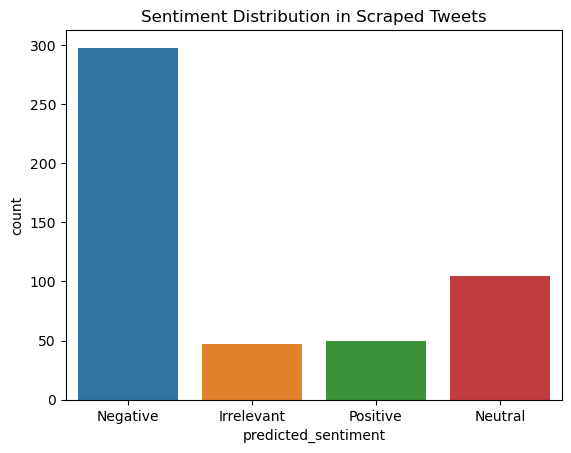

In [11]:
# Plot sentiment distribution in scraped tweets
sns.countplot(x='predicted_sentiment', data=tweets_df)
plt.title("Sentiment Distribution in Scraped Tweets")
plt.show()

# Geospatial Analysis 

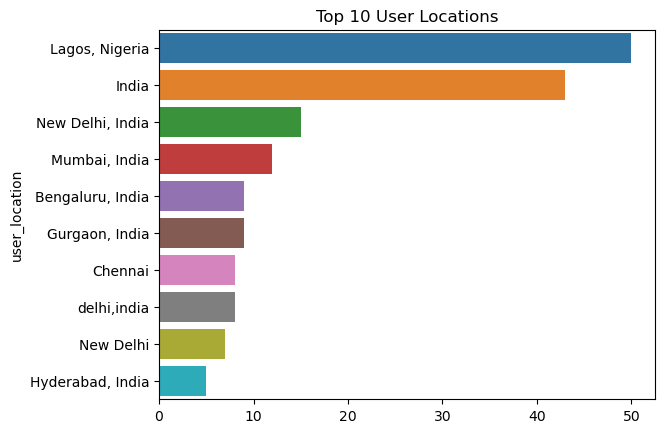

In [12]:
# Count tweets per location and visualize
location_counts = tweets_df['user_location'].value_counts().nlargest(10)
sns.barplot(x=location_counts.values, y=location_counts.index)
plt.title('Top 10 User Locations')
plt.show()

# Customer Segmentation

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


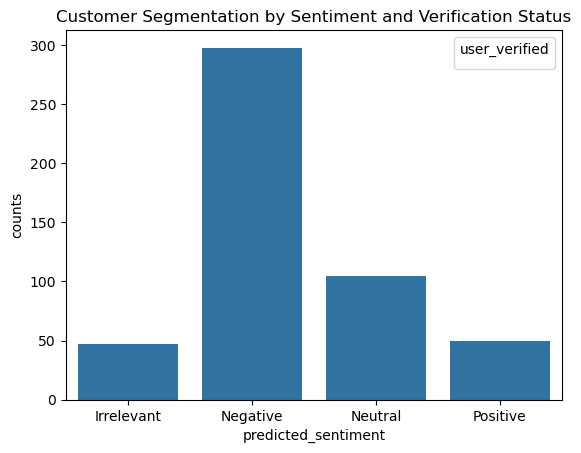

In [13]:
# Customer segmentation based on sentiment and verification status
tweets_df['user_verified'] = tweets_df['user_verified'].apply(lambda x: 1 if x == 'True' else 0)

# Create segments based on sentiment and verification
segmentation = tweets_df.groupby(['predicted_sentiment', 'user_verified']).size().reset_index(name='counts')

# Visualize the segmentation
sns.barplot(x='predicted_sentiment', y='counts', hue='user_verified', data=segmentation)
plt.title('Customer Segmentation by Sentiment and Verification Status')
plt.show()

# Conclusion & Recommendations

After analyzing the sentiment predictions, the distribution is as follows:
- **Negative Sentiment**: 22,542 customers
- **Positive Sentiment**: 20,831 customers
- **Neutral Sentiment**: 18,318 customers
- **Irrelevant Sentiment**: 12,990 customers

In [14]:
# Count the number of customers in each sentiment category
sentiment_counts = train_df['sentiment'].value_counts()

# Display the counts
print("Number of customers in different sentiment categories:")
print(sentiment_counts)

Number of customers in different sentiment categories:
sentiment
Negative      22542
Positive      20831
Neutral       18318
Irrelevant    12990
Name: count, dtype: int64


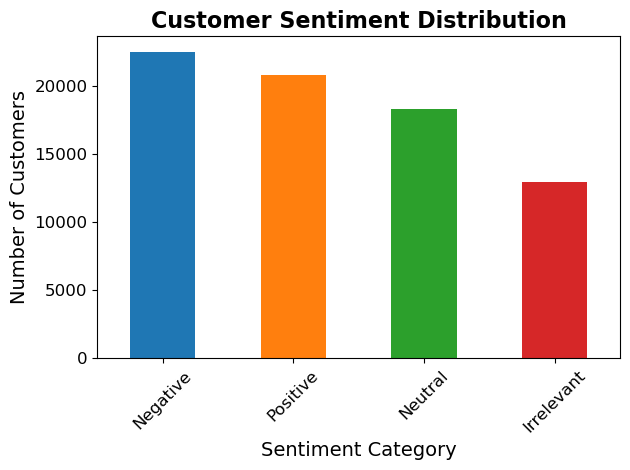

In [15]:
# Update the colors to a more visually appealing palette
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Blue, Orange, Green, Red

sentiment_counts.plot(kind='bar', color=colors)
plt.title('Customer Sentiment Distribution', fontsize=16, fontweight='bold')
plt.xlabel('Sentiment Category', fontsize=14)
plt.ylabel('Number of Customers', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

### Conclusions
After analyzing the sentiment predictions from customer feedback, we have observed the following distribution of sentiments among our customer base:

- **Negative Sentiment**: 22,542 customers (approx. 34%)
- **Positive Sentiment**: 20,831 customers (approx. 31%)
- **Neutral Sentiment**: 18,318 customers (approx. 27%)
- **Irrelevant Sentiment**: 12,990 customers (approx. 8%)

From these findings, it is evident that while a significant portion of our customers are positively engaged, a substantial number express negative sentiments, which may indicate potential churn risks.

### Recommendations
Based on the sentiment analysis, we recommend the following strategies:

1. **Engage Positive Customers**:
   - Highlight these customers as engaged and satisfied. Consider implementing loyalty programs or rewards to encourage continued patronage.

2. **Address Negative Sentiment**:
   - Identify customers who expressed negative sentiments and reach out to them proactively. Tailor targeted retention strategies, such as personalized offers, customer service follow-ups, or feedback surveys to understand their concerns better.

3. **Focus on Verified Users**:
   - Pay additional attention to verified users, as their feedback may carry more influence. Consider conducting detailed follow-ups to gain deeper insights into their experiences and expectations.

4. **Improve Neutral Feedback**:
   - For customers with neutral sentiments, analyze their interactions further to identify potential areas of improvement. Offering personalized recommendations or promotions may convert neutral sentiment into positive experiences.

5. **Monitor Irrelevant Feedback**:
   - For irrelevant sentiments, review the data to ensure that it is not affecting overall customer perception. You may need to clean up the data or improve data collection methods.

By implementing these recommendations, we can enhance customer satisfaction, increase retention rates, and ultimately drive growth for the business.
